In [ ]:
!pip install torch_snippets
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision import datasets
import torch

In [ ]:
data_folder = '~/cifar10/cifar/'
datasets.CIFAR10(data_folder, download=True)

In [ ]:
class Colorize(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root, train)
        
    def __getitem__(self, ix):
        im, _ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw, im = np.array(bw)/255., np.array(im)/255.
        bw, im = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw,im]]
        return bw, im

In [ ]:
train_dataset = Colorize(data_folder, train=True)
valid_dataset = Colorize(data_folder, train=False)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

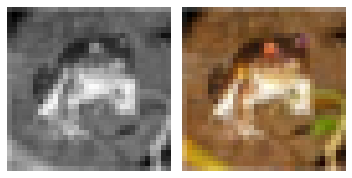

In [ ]:
a, b = train_dataset[0]
subplots([a, b], nc=2)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

class DownConv(nn.Module):
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x,y], axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv( 3, 64, maxpool=False)
        self.d2 = DownConv( 64, 128)
        self.d3 = DownConv( 128, 256)
        self.d4 = DownConv( 256, 512)
        self.d5 = DownConv( 512, 1024)
        self.u5 = UpConv (1024, 512)
        self.u4 = UpConv ( 512, 256)
        self.u3 = UpConv ( 256, 128)
        self.u2 = UpConv ( 128, 64)
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)

    def forward(self, x):
        x0 = self.d1( x) # 32
        x1 = self.d2(x0) # 16
        x2 = self.d3(x1) # 8
        x3 = self.d4(x2) # 4
        x4 = self.d5(x3) # 2
        X4 = self.u5(x4, x3)# 4
        X3 = self.u4(X4, x2)# 8
        X2 = self.u3(X3, x1)# 16
        X1 = self.u2(X2, x0)# 32
        X0 = self.u1(X1) # 3
        return X0

In [ ]:
def get_model():
  model = UNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  loss_fn = nn.MSELoss()
  return model, optimizer, loss_fn

In [ ]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  x, y = data
  _y = model(x)
  optimizer.zero_grad()
  loss = criterion(_y, y)
  loss.backward()
  optimizer.step()
  return loss.item()

def validate_batch(model, data, criterion):
  model.eval()
  x, y = data
  _y = model(x)
  loss = criterion(_y, y)
  return loss.item()

In [ ]:
model, optimizer, criterion = get_model()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
_valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [ ]:
epochs = 100
log = Report(epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 0.250	trn_loss: 0.007	(125.75s - 50175.58s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 0.255	trn_loss: 0.007	(128.24s - 50142.52s remaining)

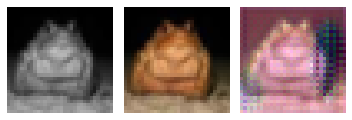

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


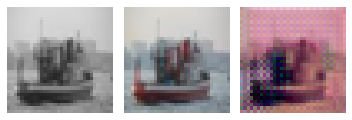

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


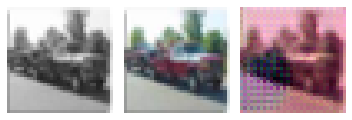

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


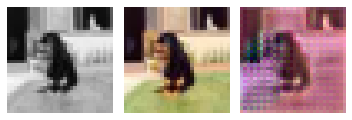

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


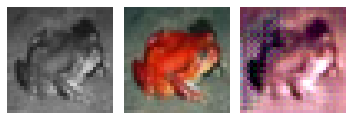

EPOCH: 0.505	trn_loss: 0.007	(251.27s - 49495.77s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 0.510	trn_loss: 0.007	(253.75s - 49480.74s remaining)

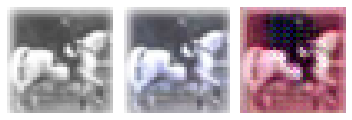

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


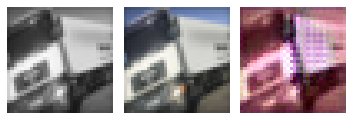

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


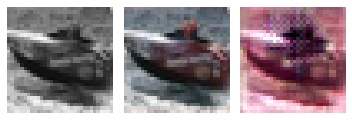

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


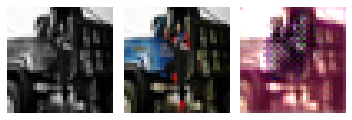

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


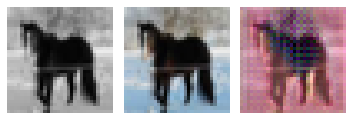

EPOCH: 0.760	trn_loss: 0.007	(376.55s - 49155.87s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 0.765	trn_loss: 0.007	(379.02s - 49146.60s remaining)

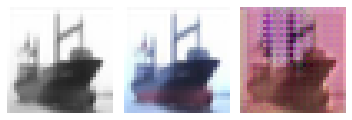

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


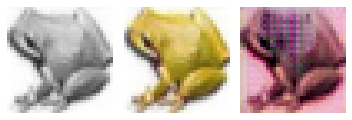

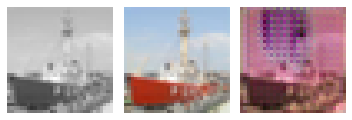

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


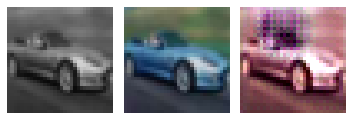

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


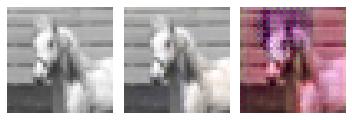

EPOCH: 1.000	val_loss: 0.005	(512.63s - 50750.41s remaining)

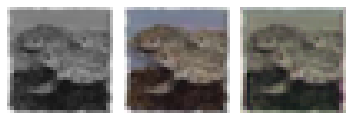

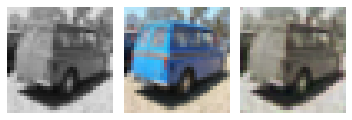

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


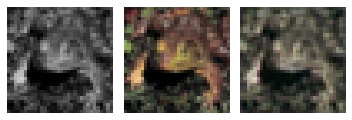

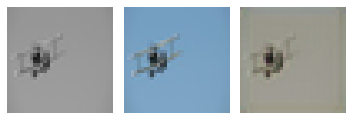

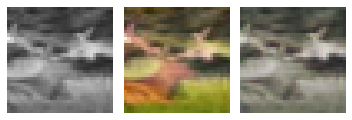

EPOCH: 1.250	trn_loss: 0.007	(635.48s - 50203.10s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1.255	trn_loss: 0.006	(637.96s - 50191.29s remaining)

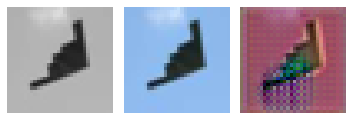

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


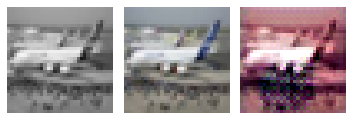

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


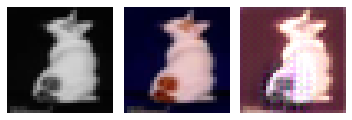

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


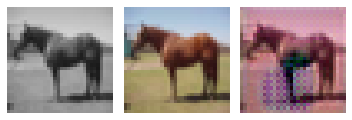

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


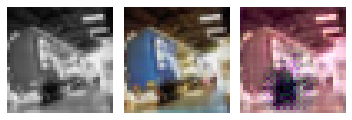

EPOCH: 1.505	trn_loss: 0.006	(761.06s - 49803.96s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1.510	trn_loss: 0.006	(763.54s - 49795.06s remaining)

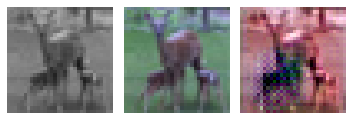

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


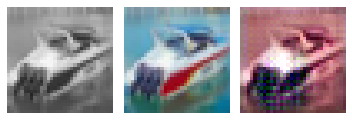

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


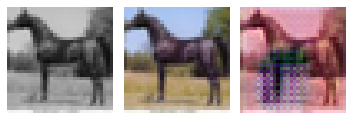

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


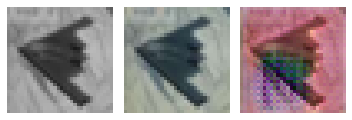

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


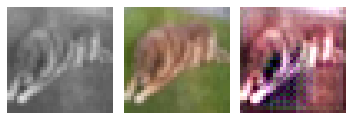

EPOCH: 1.760	trn_loss: 0.006	(886.69s - 49487.69s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1.765	trn_loss: 0.007	(889.17s - 49480.14s remaining)

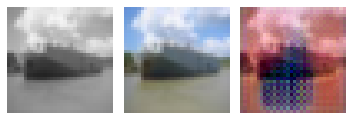

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


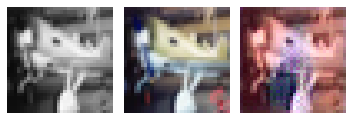

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


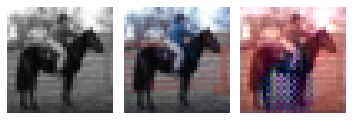

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


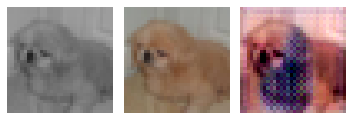

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


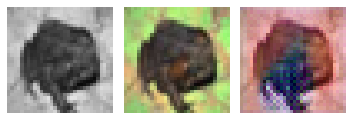

EPOCH: 1.975	val_loss: 0.006	(1022.23s - 50736.40s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 2.000	val_loss: 0.004	(1022.78s - 50116.19s remaining)

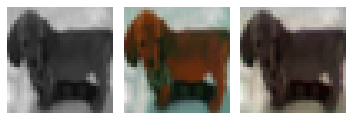

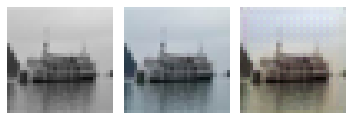

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


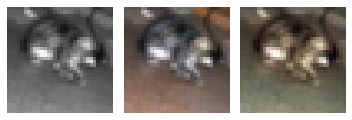

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


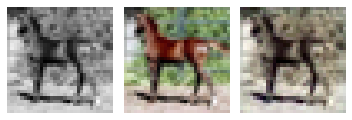

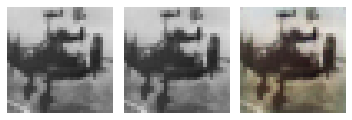

EPOCH: 2.250	trn_loss: 0.006	(1146.20s - 49796.07s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 2.255	trn_loss: 0.005	(1148.68s - 49788.35s remaining)

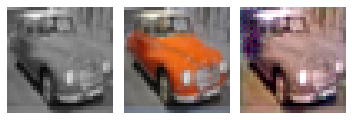

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


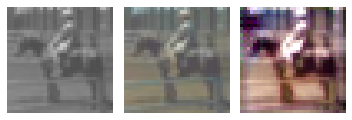

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


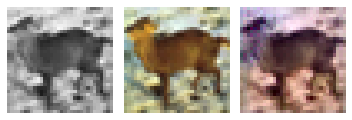

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


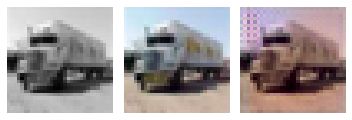

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


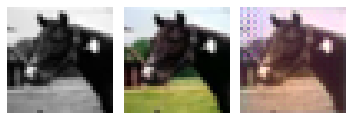

EPOCH: 2.505	trn_loss: 0.006	(1271.71s - 49493.11s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 2.510	trn_loss: 0.005	(1274.19s - 49486.18s remaining)

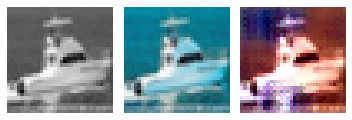

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


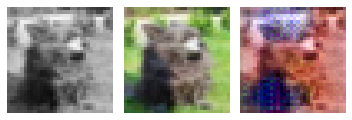

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


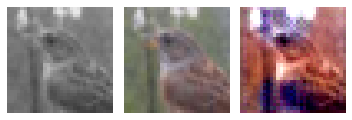

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


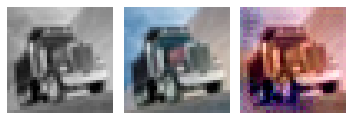

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


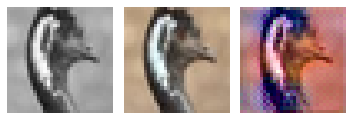

EPOCH: 2.760	trn_loss: 0.006	(1397.18s - 49221.57s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 2.765	trn_loss: 0.006	(1399.66s - 49215.48s remaining)

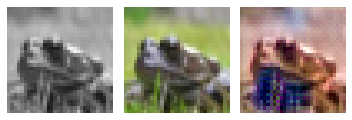

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


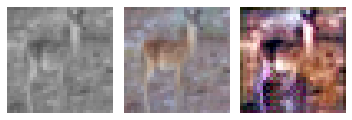

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


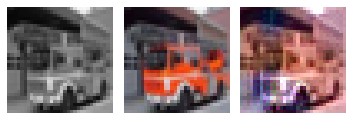

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


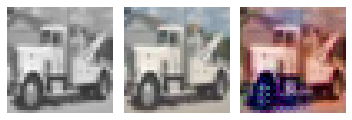

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


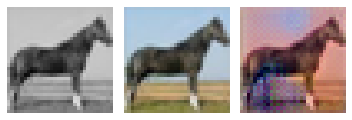

EPOCH: 2.975	val_loss: 0.005	(1531.58s - 49950.22s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 3.000	val_loss: 0.004	(1532.12s - 49538.65s remaining)

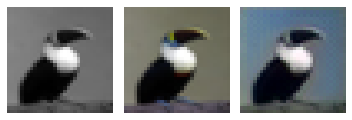

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


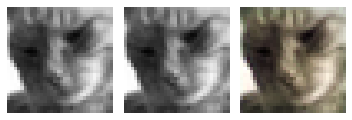

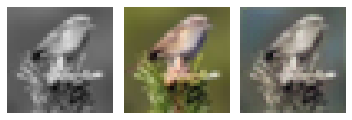

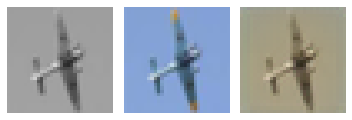

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


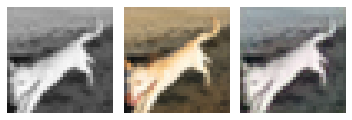

EPOCH: 3.250	trn_loss: 0.005	(1655.55s - 49284.32s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 3.255	trn_loss: 0.005	(1658.03s - 49278.27s remaining)

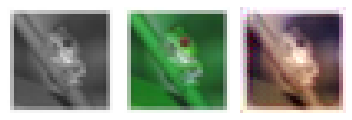

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


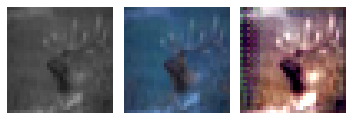

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


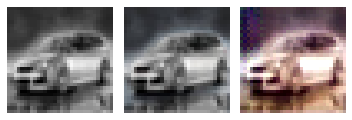

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


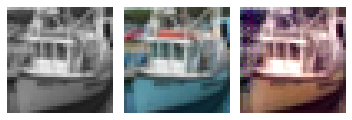

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


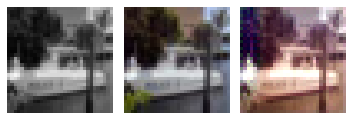

EPOCH: 3.505	trn_loss: 0.005	(1781.47s - 49043.67s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 3.510	trn_loss: 0.006	(1783.96s - 49038.16s remaining)

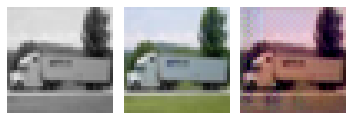

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


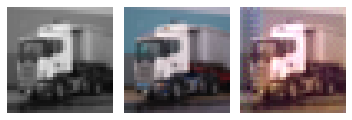

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


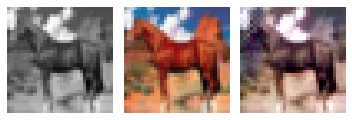

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


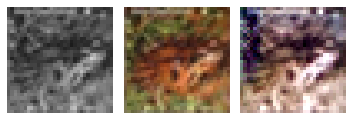

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


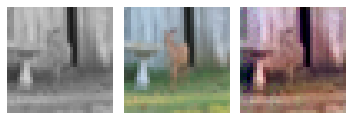

EPOCH: 3.760	trn_loss: 0.005	(1907.39s - 48818.34s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 3.765	trn_loss: 0.006	(1909.88s - 48813.12s remaining)

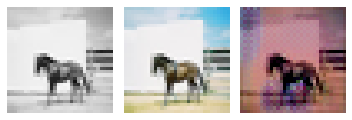

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


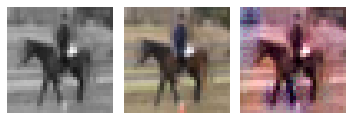

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


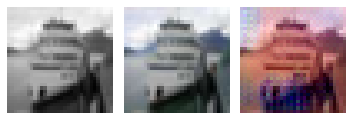

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


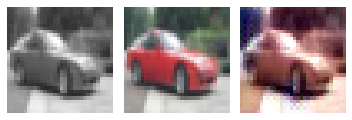

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


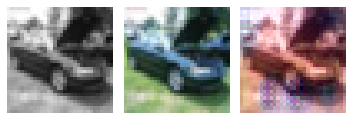

EPOCH: 4.000	val_loss: 0.004	(2042.81s - 49027.47s remaining)

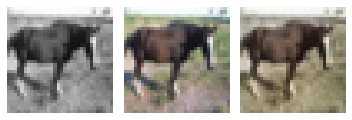

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


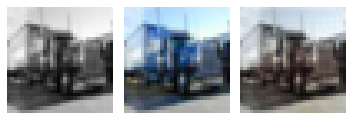

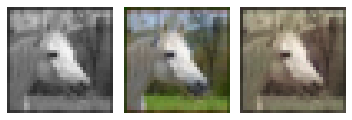

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


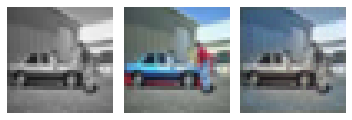

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


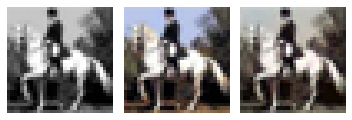

EPOCH: 4.250	trn_loss: 0.005	(2165.61s - 48789.86s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 4.255	trn_loss: 0.006	(2168.08s - 48784.42s remaining)

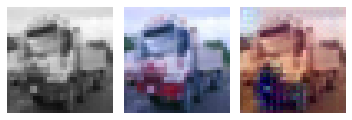

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


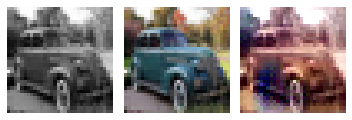

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


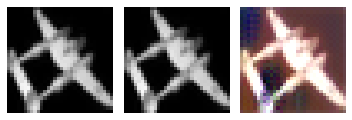

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


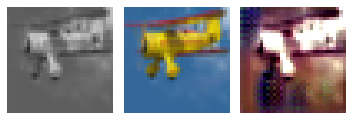

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


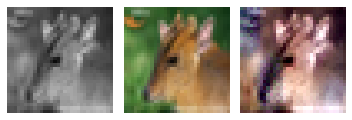

EPOCH: 4.505	trn_loss: 0.006	(2290.92s - 48560.69s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 4.510	trn_loss: 0.005	(2293.39s - 48555.54s remaining)

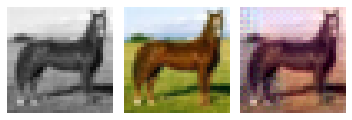

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


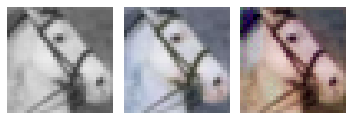

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


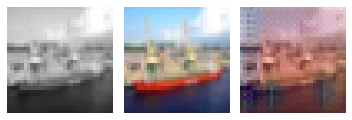

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


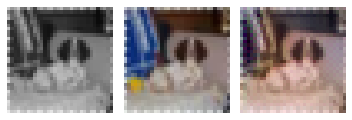

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


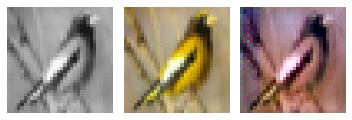

EPOCH: 4.760	trn_loss: 0.005	(2416.09s - 48339.84s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 4.765	trn_loss: 0.005	(2418.56s - 48334.92s remaining)

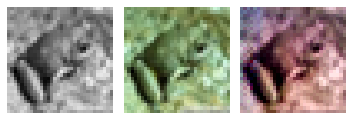

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


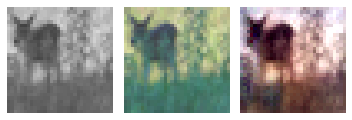

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


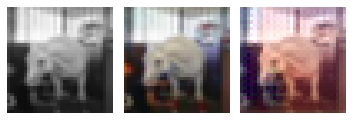

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


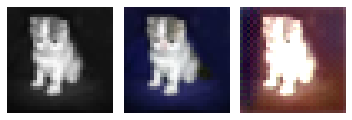

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


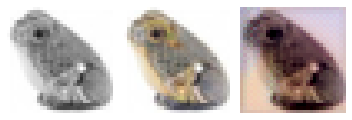

EPOCH: 5.000	trn_loss: 0.005	val_loss: 0.005	(2551.18s - 48472.44s remaining)


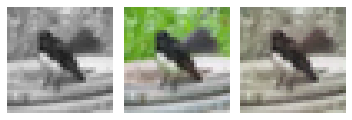

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


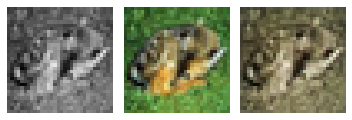

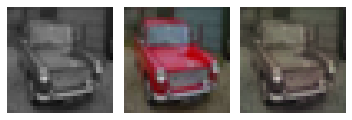

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


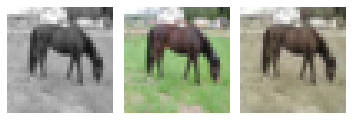

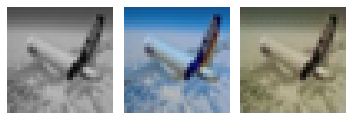

EPOCH: 5.250	trn_loss: 0.005	(2674.01s - 48259.54s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 5.255	trn_loss: 0.006	(2676.49s - 48254.71s remaining)

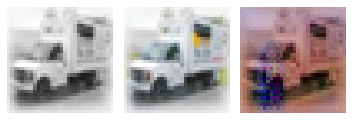

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


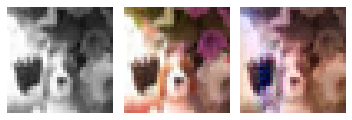

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


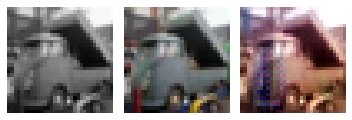

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


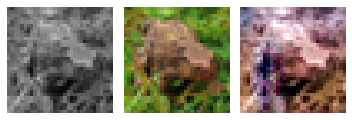

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


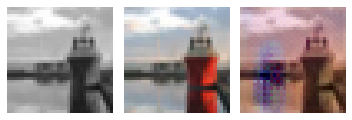

EPOCH: 5.505	trn_loss: 0.006	(2799.42s - 48051.87s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 5.510	trn_loss: 0.005	(2801.89s - 48047.31s remaining)

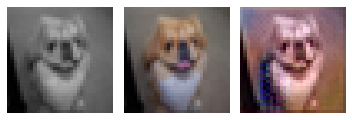

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


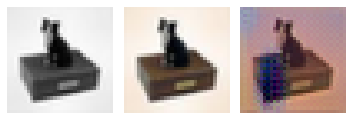

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


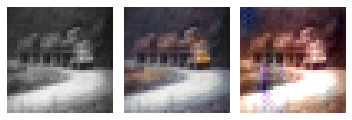

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


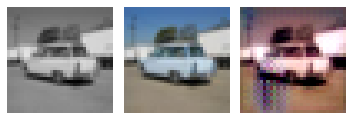

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


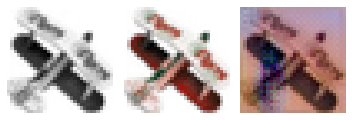

EPOCH: 5.765	trn_loss: 0.005	(2927.35s - 47847.93s remaining)

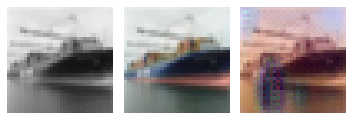

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


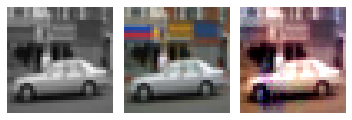

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


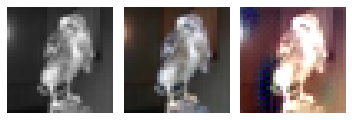

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


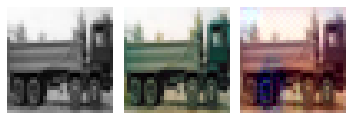

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


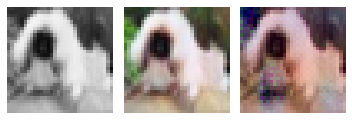

EPOCH: 5.975	val_loss: 0.006	(3059.44s - 48144.53s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 6.000	val_loss: 0.004	(3059.98s - 47939.66s remaining)

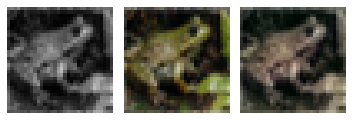

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


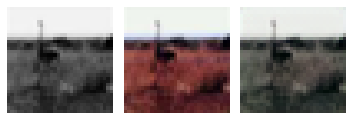

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


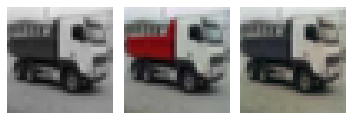

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


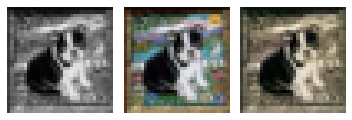

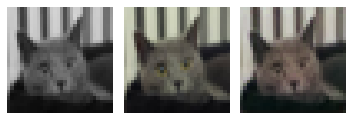

EPOCH: 6.250	trn_loss: 0.005	(3182.92s - 47743.83s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 6.255	trn_loss: 0.006	(3185.40s - 47739.41s remaining)

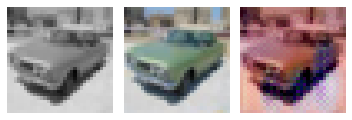

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


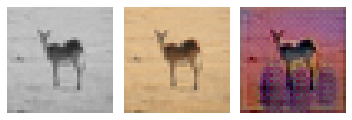

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


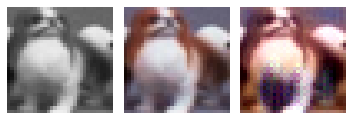

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


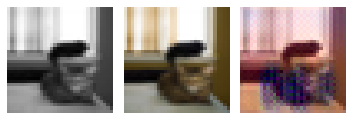

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


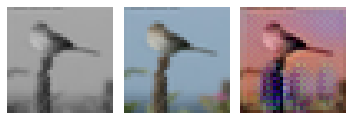

EPOCH: 6.505	trn_loss: 0.005	(3308.11s - 47545.99s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 6.510	trn_loss: 0.006	(3310.59s - 47541.67s remaining)

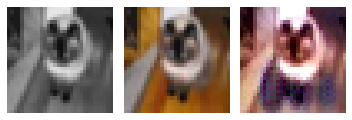

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


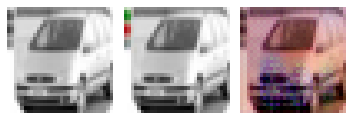

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


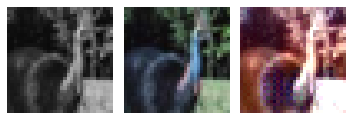

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


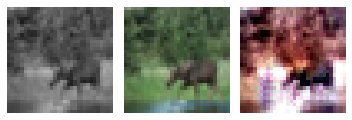

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


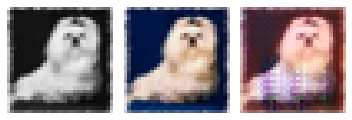

EPOCH: 6.760	trn_loss: 0.005	(3433.49s - 47356.21s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 6.765	trn_loss: 0.005	(3435.97s - 47352.15s remaining)

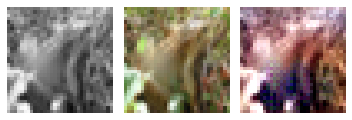

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


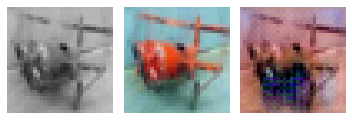

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


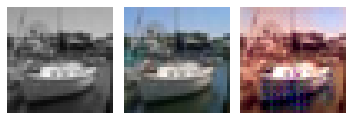

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


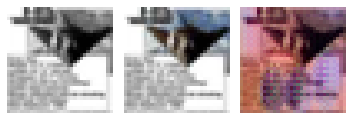

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


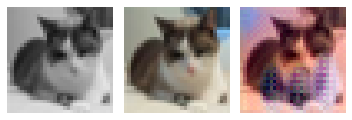

EPOCH: 7.000	val_loss: 0.004	(3568.37s - 47408.31s remaining)

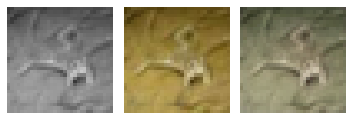

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


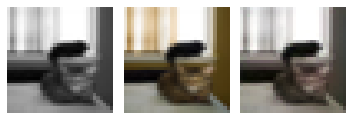

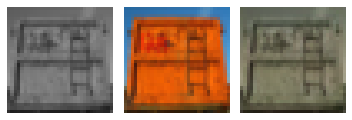

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


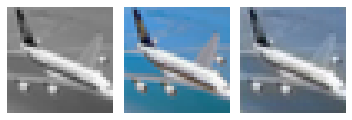

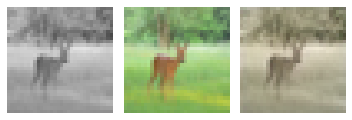

EPOCH: 7.250	trn_loss: 0.005	(3691.52s - 47225.99s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 7.255	trn_loss: 0.004	(3694.01s - 47221.96s remaining)

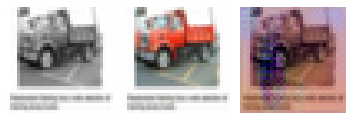

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


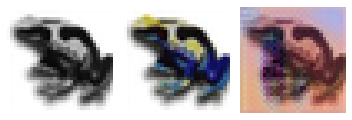

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


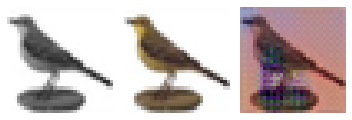

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


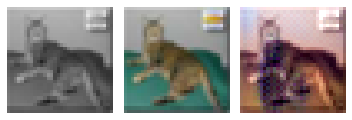

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


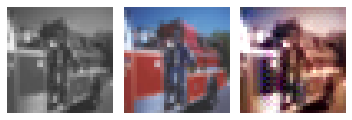

EPOCH: 7.505	trn_loss: 0.006	(3817.23s - 47044.56s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 7.510	trn_loss: 0.006	(3819.72s - 47040.68s remaining)

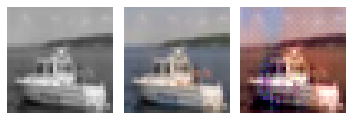

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


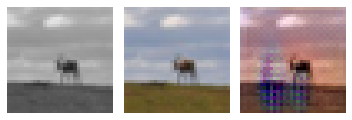

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


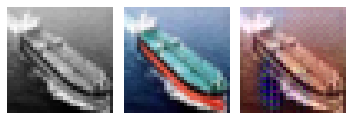

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


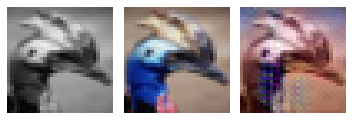

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


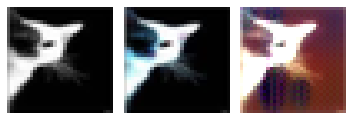

EPOCH: 7.760	trn_loss: 0.005	(3943.14s - 46869.14s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 7.765	trn_loss: 0.006	(3945.62s - 46865.24s remaining)

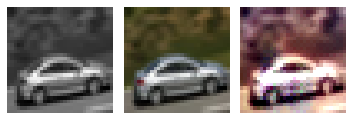

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


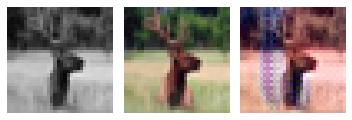

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


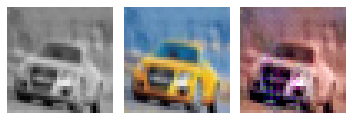

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


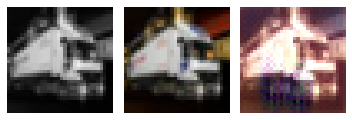

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


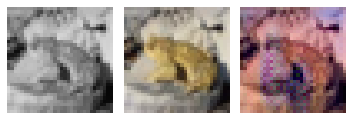

EPOCH: 8.000	val_loss: 0.003	(4078.35s - 46901.08s remaining)

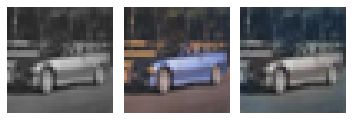

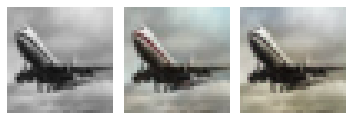

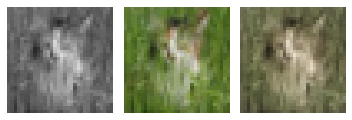

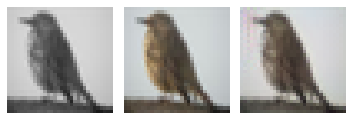

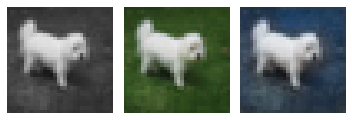

EPOCH: 8.250	trn_loss: 0.005	(4201.26s - 46723.15s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 8.255	trn_loss: 0.005	(4203.75s - 46719.28s remaining)

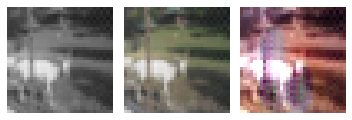

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


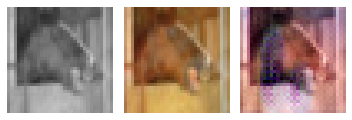

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


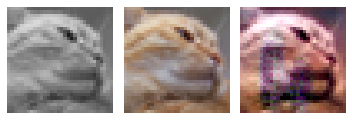

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


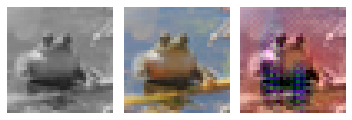

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


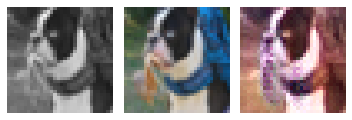

EPOCH: 8.505	trn_loss: 0.006	(4326.92s - 46547.49s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 8.510	trn_loss: 0.005	(4329.41s - 46543.70s remaining)

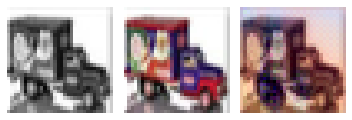

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


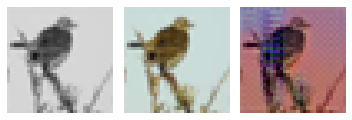

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


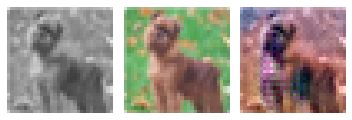

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


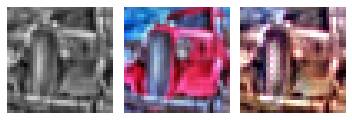

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


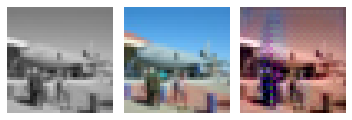

EPOCH: 8.760	trn_loss: 0.005	(4452.38s - 46372.70s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 8.765	trn_loss: 0.005	(4454.86s - 46368.90s remaining)

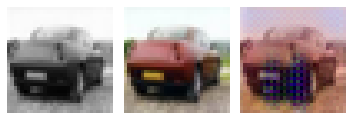

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


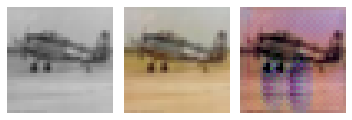

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


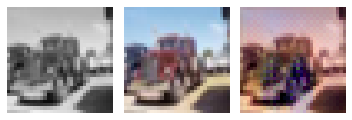

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


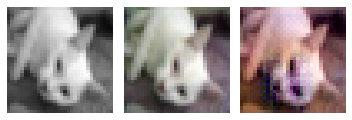

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


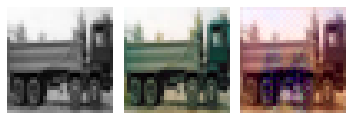

EPOCH: 8.975	val_loss: 0.006	(4587.06s - 46522.25s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 9.000	val_loss: 0.004	(4587.60s - 46385.75s remaining)

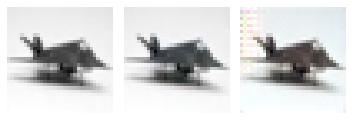

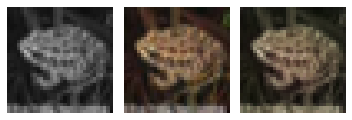

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


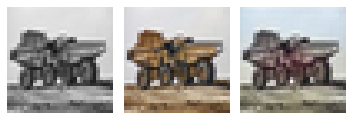

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


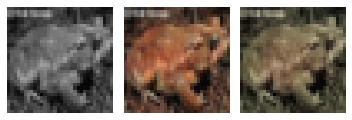

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


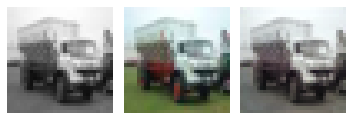

EPOCH: 9.250	trn_loss: 0.004	(4710.53s - 46214.09s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 9.255	trn_loss: 0.006	(4713.01s - 46210.34s remaining)

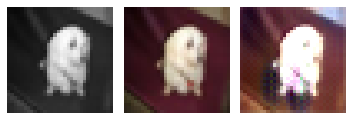

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


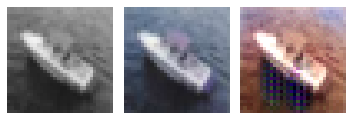

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


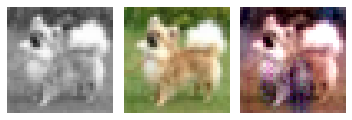

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


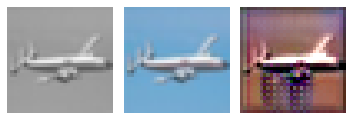

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


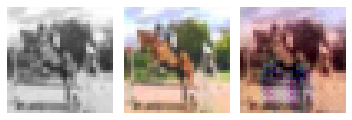

EPOCH: 9.505	trn_loss: 0.006	(4836.08s - 46042.74s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 9.510	trn_loss: 0.006	(4838.57s - 46039.06s remaining)

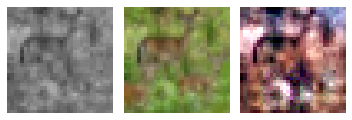

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


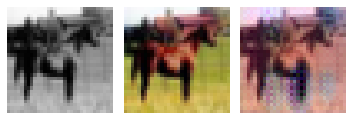

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


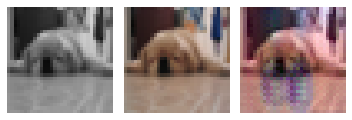

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


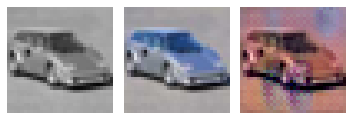

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


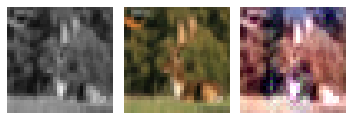

EPOCH: 9.760	trn_loss: 0.004	(4961.68s - 45874.17s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 9.765	trn_loss: 0.005	(4964.17s - 45870.60s remaining)

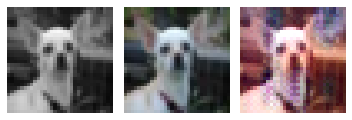

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


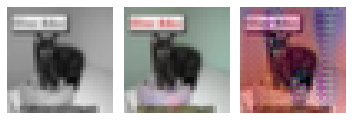

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


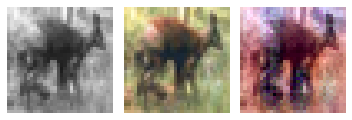

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


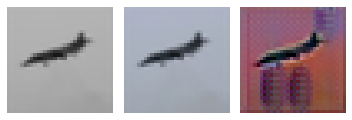

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


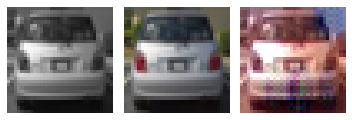

EPOCH: 10.000	trn_loss: 0.005	val_loss: 0.006	(5097.13s - 45874.16s remaining)


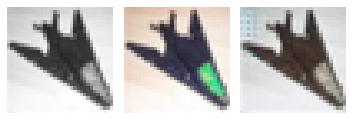

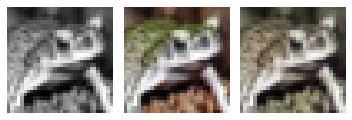

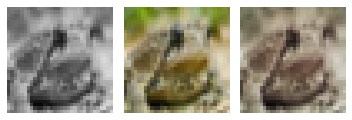

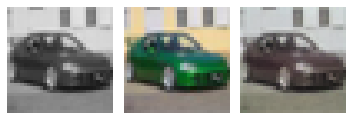

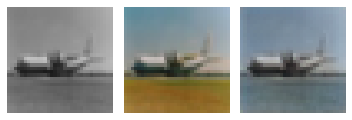

EPOCH: 10.250	trn_loss: 0.004	(5220.39s - 45710.28s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 10.255	trn_loss: 0.005	(5222.88s - 45706.66s remaining)

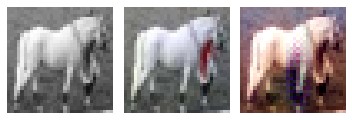

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


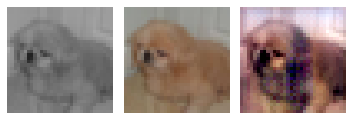

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


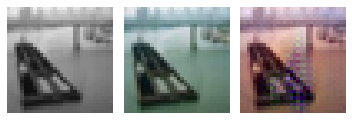

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


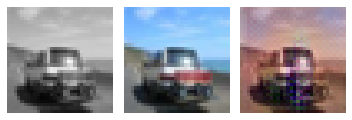

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


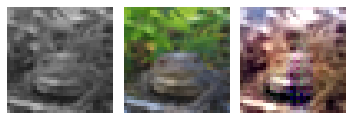

EPOCH: 10.505	trn_loss: 0.005	(5346.18s - 45545.11s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 10.510	trn_loss: 0.005	(5348.66s - 45541.52s remaining)

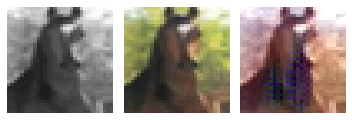

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


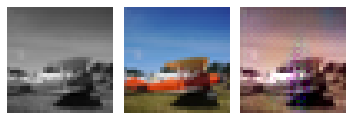

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


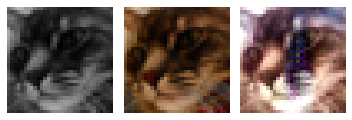

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


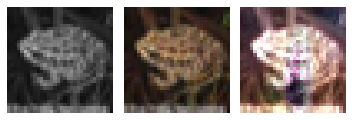

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


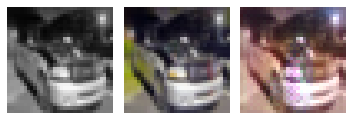

EPOCH: 10.760	trn_loss: 0.004	(5472.11s - 45382.94s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 10.765	trn_loss: 0.005	(5474.59s - 45379.39s remaining)

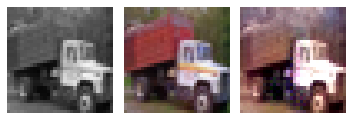

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


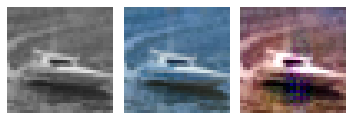

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


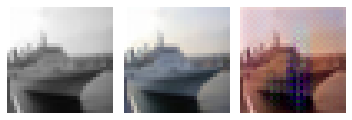

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


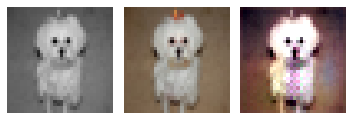

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


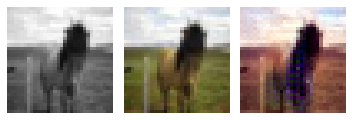

EPOCH: 10.975	val_loss: 0.005	(5607.16s - 45483.16s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 11.000	val_loss: 0.004	(5607.70s - 45371.42s remaining)

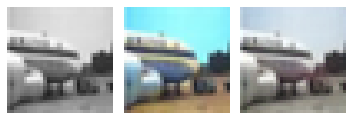

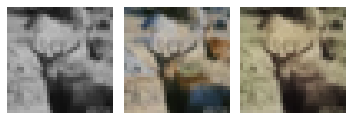

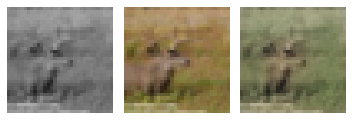

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


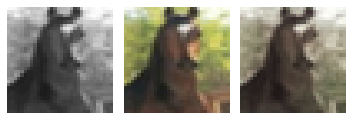

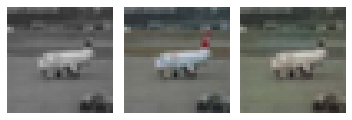

EPOCH: 11.168	trn_loss: 0.005	(5691.19s - 45266.92s remaining)

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epochs):
  N = len(train_dataloader)
  for bx, data in enumerate(train_dataloader):
    loss = train_batch(model, data, optimizer, criterion)
    log.record(epoch + (bx + 1) / N, trn_loss=loss, end='\r')
    if (bx+1) % 50 == 0:
      for _ in range(5):
        a, b = next(iter(_valid_dataloader))
        _b = model(a)
        subplots([a[0], b[0], _b[0]], nc=3, figsize=(5, 5))
  N = len(valid_dataloader)
  for bx, data in enumerate(valid_dataloader):
    loss = validate_batch(model, data, criterion)
    log.record(epoch + (bx + 1) / N, val_loss=loss, end='\r')
  exp_lr_scheduler.step()
  if (epoch + 1) % 5 == 0:
    log.report_avgs(epoch + 1)
  for _ in range(5):
    a, b = next(iter(_valid_dataloader))
    _b = model(a)
    subplots([a[0], b[0], _b[0]], nc=3, figsize=(5, 5))
log.plot_epochs()